In [3]:
from qiskit import QuantumCircuit, Aer, execute, IBMQ
from qiskit.visualization import plot_histogram, plot_state_qsphere
import math
import numpy as np
from IPython.display import Image, HTML
%matplotlib inline

# Grover's algorithm
### What is it made for ?
Goal : find a value that match a criterion in a list of values.
<img src='grover_ressource/grover_list.png'/>  

### How ?

A quantum circuit create a superposition of all the states present in the list. For example, if we have the list $[|00\rangle,|01\rangle,|10\rangle,|11\rangle]$, the superposition created will be $\frac{1}{2}(|00\rangle+|01\rangle+|10\rangle+|11\rangle)$.

From this superposition, we are looking for a winner $w$ that respects certain criterion. For example, if we are looking for the number $3$, we want the first qubit to be measured to 1 and the second to 1 and thus the winner is $|11\rangle$.

1. Starting point : 
<img src='grover_ressource/grover_step1.jpg'/>
Taken from https://qiskit.org/textbook/ch-algorithms/grover.html

In [4]:
#Lets take for example a superposition |00>,|01>,|10>,|11>
qc = QuantumCircuit(2)
qc.h(range(2)) #applying two hadamard gates make the said superposition

sv = Aer.get_backend('statevector_simulator')
job = execute(qc,sv)
print("The created superposition is :")
display(job.result().get_statevector().draw(output = 'latex'))

The created superposition is :


<IPython.core.display.Latex object>

2. Oracle application : 
The oracle is the circuit that will tell if the state follows the criterion or not. If it does, then the phase of the corresopnding state is inverted.
<img src='grover_ressource/grover_step2.jpg'/>
Taken from https://qiskit.org/textbook/ch-algorithms/grover.html

In [5]:
#Lets say that we are looking for the state |11>
#The oracle to detect this state is the following : 
ora = QuantumCircuit(2, name = 'oracle |11>')
#The control-z gate will apply a phase to our second qubit 
#only if both qubit are in state |1>
ora.cz(0,1) 

qc.append(ora.to_gate(), range(2))#Apply the oracle to our circuit

job = execute(qc,sv)
print("A phase has been introduced for state |11> :")
display(job.result().get_statevector().draw(output = 'latex'))

A phase has been introduced for state |11> :


<IPython.core.display.Latex object>

3. Phase amplification :
A reflection is now applied relative to the old phase of every elements, in order to increase the probability of measuring the winner state.
<img src = 'grover_ressource/grover_step3.jpg'/>
Taken from https://qiskit.org/textbook/ch-algorithms/grover.html

4. Repeat $\sqrt N$ times, with $N$ the amount of criterion (which equals the amount of qubits).

In [6]:
#We now want to amplify the phase to make our winner stick out
ref = QuantumCircuit(2)
ref.h(range(2))
ref.x(range(2))
ref.cz(0,1)
ref.x(range(2))
ref.h(range(2))

qc.append(ref.to_gate(), range(2))

job = execute(qc,sv)
print("Now the measurements are :")
display(job.result().get_counts())

Now the measurements are :


{'11': 1.0}

As we only have two qubits, we needed to repeat the oracle-reflection combination only $\lfloor \sqrt 2 \rfloor= 1$ times

### Concrete application using Qiskit's prebuilt algorithms 

In [7]:
from qiskit.algorithms import Grover,AmplificationProblem
from qiskit.circuit.library.phase_oracle import PhaseOracle
from qiskit.visualization import plot_histogram
from qiskit.utils import QuantumInstance

### What spice to use
Eric wants to season its pasta plates and has a lot of spices in its kitchen. As Eric has the access to a quantum computer, he decides to input all of his requirements to Grover's algorithm for it to output the best seasoning for its pasta.

In his kitchen, Eric has : 

Seasoning | Spicy ? (c1) | Sweet ? (c2) | Salty ? (c3) | Dry ? (c4) | Bad nutritional score ? (c5) | Encoding
:-:|:-:|:-:|:-:|:-:|:-:|:-:
 Ketchup | no | yes | yes | no | yes | \|$01101\rangle$
 Soy sauce | no | no | yes | no | no | \|$00100\rangle$
 Chili paste | yes | no | yes | yes | no | \|$10110\rangle$
 Heavy cream | no | no | no | no | yes | \|$00001\rangle$
 Dry pasta seasoning | yes | no | no | yes | no | \|$10010\rangle$

Now say that Eric wants the following seasoning for its lunch:
Non-spicy, Salty, already liquid , with a good nutritional score.
Eric can then encode its desire in the following binary expression : 
$\neg c1 \wedge \neg c2 \wedge c3 \wedge \neg c4 \wedge \neg c5$

We can use Qiskit's algorithm library to compile the boolean expression into an oracle : 

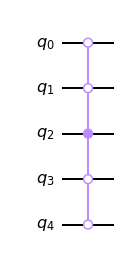

In [8]:
expr = "~c1&~c2&c3&~c4&~c5"
oracle = PhaseOracle(expr)
oracle.draw(output = 'mpl')

We now have our oracle. Qiskit also provides a way to combine the oracle with the amplification part of the Grover algorithm : 

In [9]:
problem = AmplificationProblem(oracle,is_good_state=oracle.evaluate_bitstring)
# We setup our amplification problem with the oracle and we tell the created object which state 
#is a winner state according to the oracle

And everything can be brought together into a Grover problem, that can then be run (or amplified) to find the winner.

In [10]:
backend = Aer.get_backend('qasm_simulator')
#We setup our grover object that will execute our problem
algorithm = Grover(quantum_instance=QuantumInstance(backend, shots = 1024))
#We execute Grover's algorithm on our amplification problem. The number of iterations is 
#determined in the function amplify
result = algorithm.amplify(problem)
#We reverse the bitstring as Qiskit's measurement are in the wrong order
result.top_measurement[::-1]

'00100'

We make a simple function to understand what our result corresponds to :

In [11]:
def the_sauce(result):
    season_dict = {'01101':'Ketchup', '00100' : 'Soy Sauce', '10110' : 'Chili paste', '00001' : 'Heavy cream','10010' : 'Dry pasta seasoning'}
    res = season_dict.get(result.top_measurement[::-1])
    if res is not None : 
        return res
    else:
        print("The sauce with the code ",result.top_measurement[::-1]," does not exists")

print("The selected sauce is : ",the_sauce(result))

The selected sauce is :  Soy Sauce


And finally we can plot the probability distribution to see if there was any hesitation on the result : 


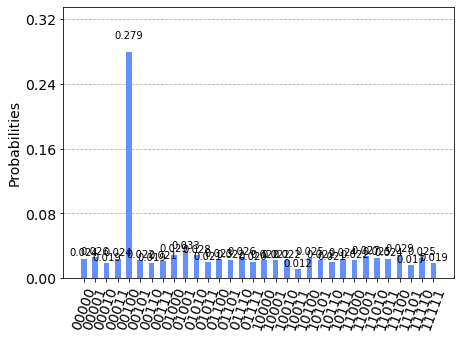

In [12]:
plot_histogram(result.circuit_results)

### Is it working that well on a real backend ?

In [13]:
from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy

account = IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-internal', group='support', project='core-team')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits == 5
                                    and not x.configuration().simulator
                                    and x.status().operational==True))
from qiskit.tools.jupyter import job_watcher
%qiskit_job_watcher

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

In [16]:
# The least busy real backend with 5 qubits has been selected
print("The least busy backend is : ",backend)
#We setup our grover object that will execute our problem
algorithm = Grover(quantum_instance=QuantumInstance(backend,shots = 1024), iterations =
                   int(math.sqrt(problem.oracle.num_qubits)))
#We execute Grover's algorithm on our amplification problem. The number of iterations 
#is determined in the function amplify
result = algorithm.amplify(problem)
#We reverse the bitstring as Qiskit's measurement are in the wrong order
print("top measurement :",result.top_measurement[::-1])
print(the_sauce(result))


The least busy backend is :  ibmq_quito
top measurement : 10101
The sauce with the code  10101  does not exists
None


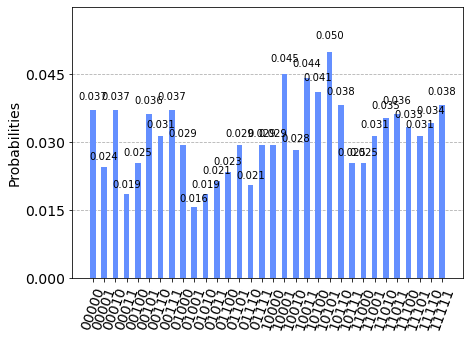

In [17]:
display(plot_histogram(result.circuit_results))